<a target="_blank" href="https://colab.research.google.com/github/IngCarlaPezzone/Hospitalizacion_pacientes_biopsia_prostatica/blob/main/03_modelo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Modelo de Machine Learning

Una vez preparados los datos, se procede a buscar un modelo de Machine Learning de clasificación, que permita clasificar a un paciente como *hospitalizado* o *no hospitalizado*, teniendo en cuenta la información referente a sus antecedentes como paciente, las morbilidad asociadas, los antecedentes relacionados con la toma de la biopsia y complicaciones infecciosas.

Para ello, se plantean dos estrategias para esa busqueda. Por un lado, utilizar las 12 columnas de datos y, en una segunda estrategia, se considera la reducción de dimensionalidad. Para ambas estrategias se utilizan los algoritmos de Árbol de Decisión, K-Vecinos Cernanos y Máquina de Soporte de Vectores.

Para la elección de los mejores hiperparámetros de cada uno de ellos, se utiliza una búsqueda exaustiva mediante la técnica de GridSearch.

A continuación, se describen cada uno de los pasos seguidos y la elección del mejor modelo.

# Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import utils

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import ConfusionMatrixDisplay

sns.set_style("white")
import warnings
warnings.simplefilter("ignore")

In [2]:
# Instalar si no se tiene para hacer el balanceo de las clases
#pip install imbalanced-learn

# Carga de los datos

Se cargan los datos limpios y transformados. Todo el procesamiento se puede ver en [ETL](01_ETL.ipynb) y [EDA](02_EDA.ipynb).

In [3]:
archivo = 'datos/BBDD_Hospitalizacion_codificado.csv'
df = pd.read_csv(archivo)
print(f'Se cargaron los datos del archivo {archivo}')

Se cargaron los datos del archivo datos/BBDD_Hospitalizacion_codificado.csv


# Exploración inicial

Para comenzar, se realiza una exploración inicial de Dataframe, para reconocer sus variables y y estructura del mismo.

In [4]:
df

,edad,diabetes,psa,biopsias_prev,vol_prostatico,antibiotico_en_profilaxis,nro_muestras,epoc,biopsia,fiebre,itu,tipo_cultivo,hospitalizacion
0,53,0,4.0,0,1,1,12,0,7,1,0,2,1
1,56,0,7.7,0,1,1,12,0,7,1,0,2,1
2,57,0,29.0,1,1,1,24,0,7,1,0,0,1
3,56,0,7.0,0,1,1,12,0,7,1,0,2,1
4,55,0,29.0,1,1,1,24,0,7,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,55,0,5.0,0,0,1,12,0,2,0,0,2,0
427,70,1,18.0,0,1,1,12,0,7,0,0,2,0
428,75,0,75.0,0,1,1,12,0,3,0,0,2,0
429,67,0,6.0,0,1,1,12,0,1,0,0,2,0


Se observa la distribución de los datos en función de la variable objetivo.

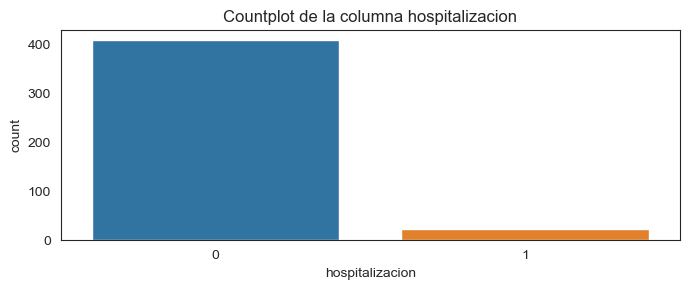

0    408
1     23
Name: hospitalizacion, dtype: int64

In [5]:
utils.countplot_vertical(df, 'hospitalizacion')
df['hospitalizacion'].value_counts()

Se observa un gran desbalaceo de las clases para la variable objetivo, siendo la clase positiva para la hospitalización solo 23 registros. Por tal motivo, se decide hacer un sobremuestreo de la variable.

# Separación de los conjuntos de entrenamiento/testeo y sobremuestreo

Dado que se observa un gran desbalance de la variable objetivo, se decide hacer el sobremuestreo de la clase minoritaria de la misma utilizando el método `RandomOverSampler` de la librería `imbalanced-learn`. 

Por otra parte, este sobremuestreo se aplica sólo a los datos del entrenamiento (train), porque el objetivo es generar instancias sintéticas de la clase minoritaria para equilibrar la distribución de clases y mejorar el rendimiento del modelo en la detección de la clase minoritaria, pero se busca que el modelo sea capaz de generalizar sobre datos reales (test). De esta manera, se preservan datos para una evaluación realista y se evitan fugas de información al conjunto de entrenamiento, enfrentando al modelo a datos realmente nuevos.

In [6]:
# Se definen X e y (variables predictoras y variable objetivo)
X = df.drop('hospitalizacion', axis=1)
y = df['hospitalizacion']

# Se divide el conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f'Para el entrenamiento quedan {y_train.value_counts()[0]} etiquetas NO y {y_train.value_counts()[1]} etiquetas SI')
print(f'Para el testeo quedan {y_test.value_counts()[0]} etiquetas NO y {y_test.value_counts()[1]} etiquetas SI')

Para el entrenamiento quedan 285 etiquetas NO y 16 etiquetas SI
Para el testeo quedan 123 etiquetas NO y 7 etiquetas SI


In [7]:
# Se crea una instancia de RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Se aplica el sobremuestreo a los datos de entrenamiento
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print(f'Para el entrenamiento quedan {y_train_ros.value_counts()[0]} etiquetas NO y {y_train_ros.value_counts()[1]} etiquetas SI')

Para el entrenamiento quedan 285 etiquetas NO y 285 etiquetas SI


# Estrategias de modelado

Como se describió al comienzo, se probaron dos estrategias para encontrar el mejor modelo que puediera considerar todas las variables que se tienen. En primer lugar, se enalizan todas las variables del conjunto de datos y luego se hace una reducción de la dimensionalidad.

## Todas las variables predictoras

Se decidió utilizar tres algoritmos de clasificación: K-Vecinos Cercanos (KNN), Árbol de Decisión (TREE) y Máquina de Soporte de Vectores (SVC). Para cada uno de ellos, se planteó la búsqueda de los mejores hiperparámetros a través de la búsqueda exaustiva de la combinación de rangos de valores para los hiperparámetros considerandos. Esto es lo que se llama Grid Search (búsqueda de grilla).

### Se define la grilla de hiperparámetros

En primer lugar se define una grilla de los hiperparámetros con los que se quiere probar cada modelo. A continuación, se instancia cada modelo y se hace el entrenamiento de cada combicación de hiperparámetro y modelo considerando una validación cruzada de 5 folds cada vez. Los resultados de las mejores métricas para cada modelo se guardan en una lista que permitirá luego comparar y graficar las matrices de confusión de cada una, para evaluar sus rendimientos.

In [8]:
# Define el rango de hiperparámetros para KNN el GridSearch
param_grid_knn = {
    'n_neighbors': np.arange(1, 20),
    'weights': ['uniform', 'distance'],
    'leaf_size':[1,3,5,7,10],
    'algorithm':['auto', 'kd_tree']
}

# Define el rango de hiperparámetros para tre el GridSearch
param_grid_tree = {
    "criterion": ['gini', 'entropy'],
    "max_depth": range(1, 20)
}

# Define el rango de hiperparámetros para SVC el GridSearch
param_grid_SVC = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

### Se hace el entrenamiento

In [9]:
# Se crea una lista para almacenar los resultados de diferentes modelos
results = []

# Se instancia y evalua el modelo K-NN
knn = KNeighborsClassifier()
knn_metrics, knn_cm_train, knn_cm_test, knn_best_params = utils.train_and_evaluate_model_estrategia1(knn, param_grid_knn, X_train_ros, y_train_ros, X_test, y_test)
results.append(('KNN', knn_metrics))

# Instanciar y evaluar el modelo Decision Tree
tree = DecisionTreeClassifier()
tree_metrics, tree_cm_train, tree_cm_test, tree_best_params = utils.train_and_evaluate_model_estrategia1(tree, param_grid_tree, X_train_ros, y_train_ros, X_test, y_test)
results.append(('Decision Tree', tree_metrics))

# Instanciar y evaluar el modelo SVC
svc = SVC(probability=True)
svc_metrics, svc_cm_train, svc_cm_test, svc_best_params = utils.train_and_evaluate_model_estrategia1(svc, param_grid_SVC, X_train_ros, y_train_ros, X_test, y_test)
results.append(('SVC', svc_metrics))

### Resultados

In [10]:
# Se presenta un resumen de las mejores métricas para cada modelo
utils.summary_results_estrtegia1(results)


,Model,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,KNN,1.0,1.0,1.0,1.0,0.961538,0.666667,0.571429,0.615385
1,Decision Tree,1.0,1.0,1.0,1.0,0.969231,0.800000,0.571429,0.666667
2,SVC,1.0,1.0,1.0,1.0,0.953846,1.000000,0.142857,0.250000


In [11]:
# Se presentan los mejores parámetros para cada modelo
print('PARÁMETROS DE LOS MEJORES MODELOS')
print('KNN:', knn_best_params)
print('Decision Tree:', tree_best_params)
print('SCV:', svc_best_params)

PARÁMETROS DE LOS MEJORES MODELOS
KNN: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 2, 'weights': 'uniform'}
Decision Tree: {'criterion': 'gini', 'max_depth': 8}
SCV: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


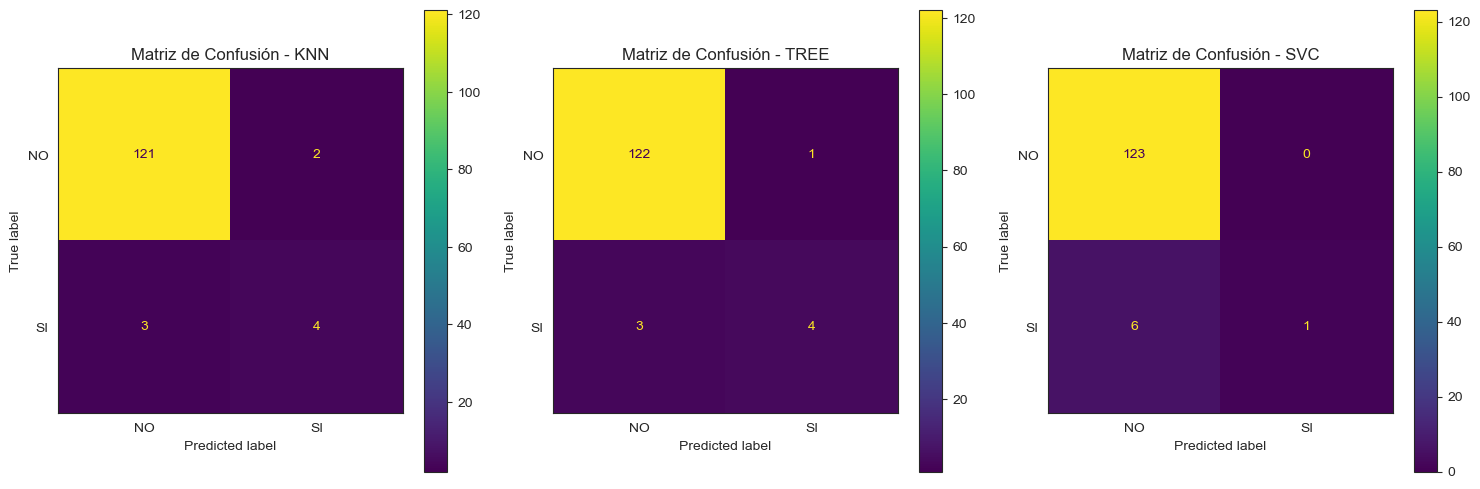

In [12]:
# Se visualizan las tres matrices de confusión
matrices = [knn_cm_test, tree_cm_test, svc_cm_test]
modelos = ['KNN', 'TREE', 'SVC']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, m in enumerate(matrices):
    ax = axes[i]
    cm_display = ConfusionMatrixDisplay(m, display_labels=['NO', 'SI'])
    cm_display.plot(ax=ax)
    ax.set_title(f'Matriz de Confusión - {modelos[i]}')

plt.tight_layout()
plt.show()

Al ser un conjunto de datos con un gran desbalanceo en la variable objetivo, se toma como métrica de evaluación F1 Score (Test_F1) dado que combina la precisión (resultados correctos sobre el total de muestras seleccionadas) y la exhaustividad (resultados correctos por sobre los resultados que se buscan identificar) de manera de mantener una relación entre las dos. Para esta métrica, **Árbol de Decisión** es el que dió un mejor F1, pero es de 0.67, aún tiene un margen grande de error en las predicciones de los que sí serán hospitalizados, tal como se visualiza en las matrices de confusión.

## Usando reducción de dimensionalidad (PCA)

Para estas segunda estrategia, se consideran analizar los mismos modelos bajo los escenarios de reducir la dimensionalidad del conjunto de datos a diferentes cantidades de componentes.

En primer lugar se estandarizan los datos utilizando `StandardScaler` que normaliza las variables numéricas en una distribución normal de media de 0 y desviación estandar de 1. A continuación, se definen 4 escenarios teneniendo en cuenta 3, 5, 8 y 10 componentes a los cuales se reducirán las variables y mediante un ciclo iterativo se reducen la dimensionalidad y entrenan cada uno de los modelos.

Las mejores métricas de cada modelo para cada escenario de PCA se guarda en un diccionario para luego comparar y visualizar.

### Se preparan los datos

In [13]:
# Se estandarizan los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ros)
X_test_scaled = scaler.transform(X_test)

### Se hace el entrenamiento

In [14]:
# Se define un diccionario para almacenar resultados
results = {}

# Se definen los números de componentes principales
num_components = [3, 5, 8, 10]

for n in num_components:
    
    # Se aplica PCA
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Se hace el entrenamiento y evaluación de los modelos
    knn_pred_train, knn_pred_test, best_knn, knn_best_params = utils.GridSearch_model(knn, param_grid_knn, X_train_pca, y_train_ros, X_test_pca, y_test)
    tree_pred_train, tree_pred_test, best_tree, tree_best_params = utils.GridSearch_model(tree, param_grid_tree, X_train_pca, y_train_ros, X_test_pca, y_test)
    svc_pred_train, svc_pred_test, best_svc, svc_best_params = utils.GridSearch_model(svc, param_grid_SVC, X_train_pca, y_train_ros, X_test_pca, y_test)
    
    # Se almacenan los resultados en el diccionario
    results[n] = {
        'KNN': (knn_pred_train, knn_pred_test, best_knn),
        'Tree': (tree_pred_train, tree_pred_test, best_tree),
        'SVC': (svc_pred_train, svc_pred_test, best_svc)
    }

### Resultados

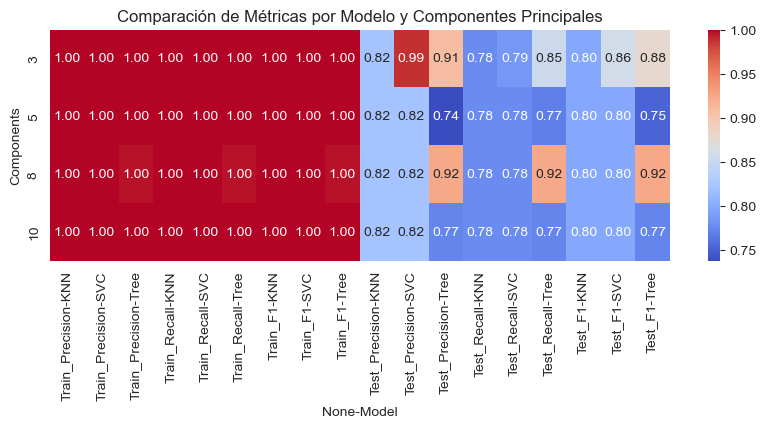

In [15]:
# Se resumen las métricas
df_summary = utils.resumen_metricas_PCA(results, y_train_ros, y_test)

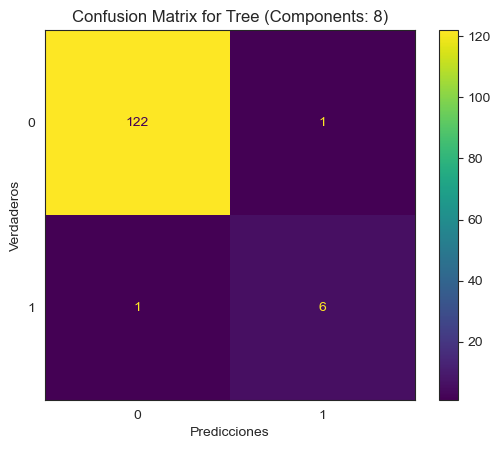

In [16]:
# Visualiza la matriz de confusión para la metrica deseada
utils.matriz_confusion_PCA(df_summary, results, y_test, 'Test_F1')

In [17]:
# Se presentan los mejores parámetros para cada modelo
print('PARÁMETROS DE LOS MEJORES MODELOS')
print('KNN:', knn_best_params)
print('Decision Tree:', tree_best_params)
print('SCV:', svc_best_params)

PARÁMETROS DE LOS MEJORES MODELOS
KNN: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 1, 'weights': 'uniform'}
Decision Tree: {'criterion': 'gini', 'max_depth': 19}
SCV: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


En este enfoque, se puede ver que el modelo que da mejores resultados es **Árbol de Decisión** para el escenario de 8 componentes de reducción de dimensionalidad. Para este caso se ve que F1 Score es de 0.92, mucho mejor que el obtenido con el primer enfoque.

# Conclusiones

Se entrenaron 3 modelos (Árbol de Decisión, K-Vecinos Cercanos y Máquina de Soporte de Vectores) teniendo en cuenta dos enfoques de análisis. Por un lado teniendo en cuenta todas las variables del conjunto de datos y, por otro lado, considerando cuatro escenarios de reducción de dimensionalidad del conjunto.

En ambos enfoques se encontró que el mejor algoritmo que clasifica los pacientes en los que se hospitalizados y no hospitalizados fue el Árbol de Decisión, pero en el caso del primer enfoque, donde se usaron todas las variables del conjunto de datos, solo llegó a un F1 Score de 0.67, bastante bajo. Sin embago, con el enfoque de reducción de la dimensionalidad, el mejor modelo fue un Árbol de decisión de máxima profundidad de 19, con criterio Gini y con 8 Componentes de reducción. En éste último caso, se llegó a un F1 Score de 0.92, siendo un muy buen rendimiento considerando el gran desbalance de la clase objetivo.